### Grupo 24

Gabriel Antunes a101101
<br>
Guilherme Pinho a105533


Um  programa imperativo pode ser descrito por um modelo do tipo Control Flow Automaton (CFA) como ilustrado no exemplo da imagem a seguir.

Este programa implementa a multiplicação de dois inteiros $\,a,b\,$ , fornecidos como “input”,    e com precisão limitada a $\,n\,$ bits (fornecido como parâmetro do programa). Note-se que
- Existe a possibilidade de alguma das operações do programa produzir um erro de “overflow”. 
- Os nós do grafo representam ações  que actuam sobre os “inputs” do nó e produzem um “output” com as operações indicadas.
- Os ramos do grafo representam ligações que transferem o “output” de um nodo para o “input” do nodo seguinte. Esta transferência é condicionada pela satisfação da condição associada ao ramo.


a. Construa um FOTS usando BitVector de tamanho $n$ que descreva o comportamento deste autómato. Para isso identifique as variáveis do modelo, o estado inicial e a relação de transição.

b. Verifique se $\;$ $\;\mathsf{P}\,\equiv\,(x*y + z = a*b)\;$ $\;$ é um invariante deste comportamento.

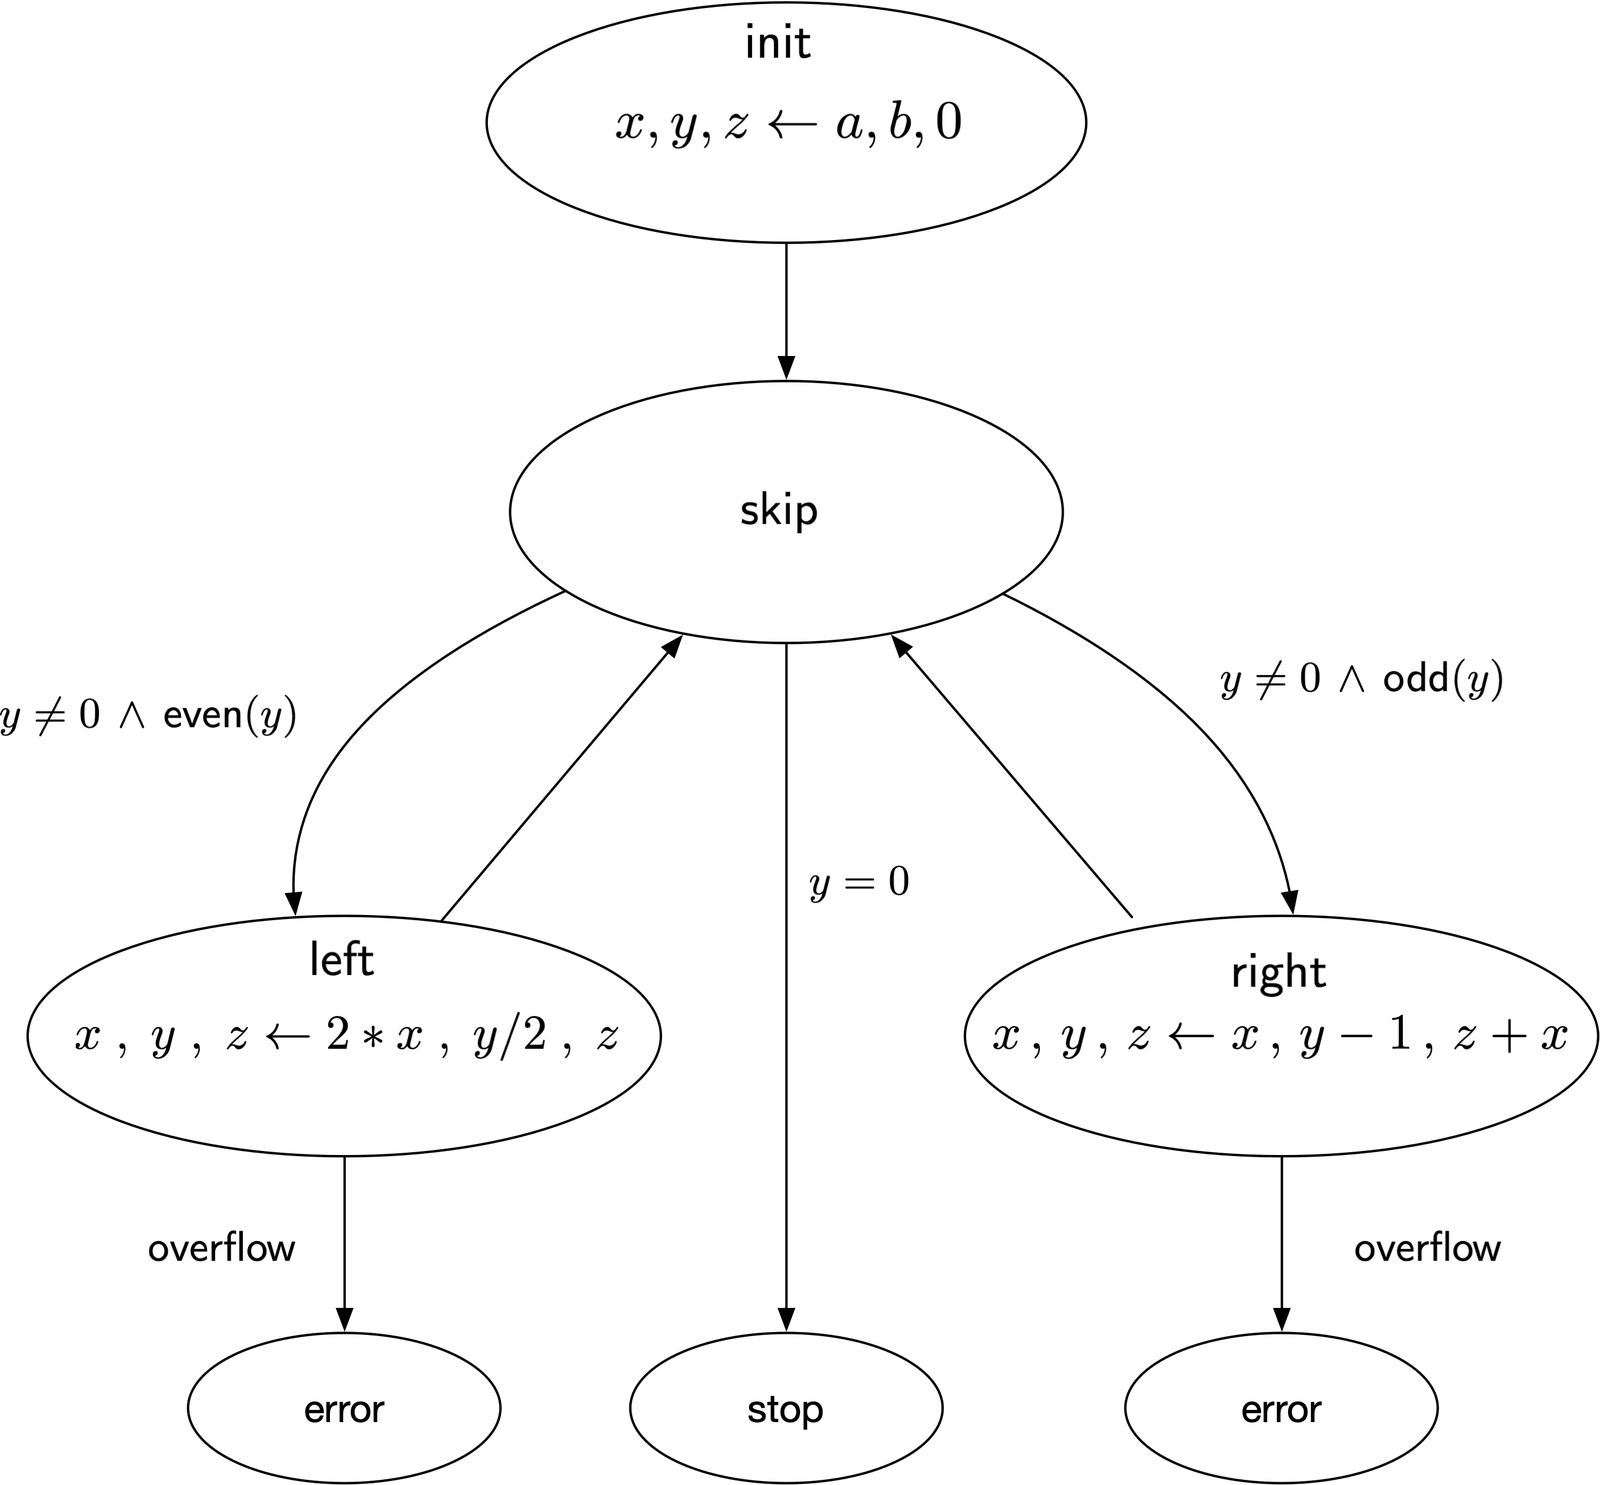

### Começo do Problema
#### Começamos por importar o módulo pysmt.shortcuts. Os tipos estão definidos no módulo pysmt.

In [37]:
from pysmt.shortcuts import *
from pysmt.typing import INT

### Modelação de predicados
O estado inicial é caracterizado pelo seguinte predicado:

$$ node = 0 \land z = 0 $$

##### Nota: 
Estado atual = node <br> Estado seguinte = node' 

As transições possíveis são caracterizadas pelo seguinte predicado:

$$ node = 0 \land (\,y \neq 0 \land even(y)\,) \land node' = 1 \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 0 \land y = 0 \land node' = 2 \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 0 \land (\,y \neq 0 \land odd(y)\,) \land node' = 3 \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 1 \land node' = 0 \land x' = 2 * x \land y' = y / 2 \land z' = z $$

$$ \lor $$

$$ node = 3 \land node' = 0 \land x' = x \land y' = y - 1 \land z' = z + x $$ 

$$ \lor $$

$$ node = 1 \land node' = 4 \land overflow \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 3 \land node' = 5 \land overflow \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 4 \land node' = 4 \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 5 \land node' = 5 \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 2 \land node' = 2 \land x' = x \land y' = y \land z' = z $$

#### A função declare cria a copia das variaveis, agrupadas num dicionario


In [38]:
def declare(i, n):
    # Cria um dicionário para armazenar as variáveis de estado
    state = {}

    state['pc'] = Symbol('pc' + str(i), INT)# Cria o símbolo para o contador de programa 'pc', representado como um inteiro
    state['x'] = Symbol('x' + str(i), types.BVType(n))# BVType(n) define um bitvector de tamanho n bits
    state['y'] = Symbol('y' + str(i), types.BVType(n))# BVType(n) define um bitvector de tamanho n bits
    state['z'] = Symbol('z' + str(i), types.BVType(n))# BVType(n) define um bitvector de tamanho n bits

    return state


#### A função init é responsavel por testar se o estado atual é um possivel inicial ou não

In [39]:
def init(state, a, b, n):
    # Retorna uma expressão lógica que define o estado inicial do sistema.
    
    return And(
        Equals(state['pc'], Int(0)),  # 'pc' é um inteiro, deve ser igual a 0 no início.
        Equals(state['x'], BV(a, n)),  # 'x' é um bitvector de tamanho 'n', deve ser igual ao valor de 'a'.
        Equals(state['y'], BV(b, n)),  # 'y' é um bitvector de tamanho 'n', deve ser igual ao valor de 'b'.
        Equals(state['z'], BV(0, n))   # 'z' é um bitvector de tamanho 'n', deve ser igual a 0.
    )

#### As funções even e odd testam se determinada variavel é impar ou par

In [40]:
def even(atual, n):
    # A função 'even' verifica se o valor de 'y' no estado atual é par.
    return Equals(BVURem(atual['y'], BV(2, n)), BV(0, n))

def odd(atual, n):
    # A função 'even' verifica se o valor de 'y' no estado atual é ímpar.
    return Not(Equals(BVURem(atual['y'], BV(2,n)), BV(0,n)))

#### A função trans testa se é possivel transitar entre dois estados

In [41]:
def trans(atual, prox, n):
    m = Int(2)
    for i in range(1, n):
        m = Times(m, Int(2))
    
    # 𝑛𝑜𝑑𝑒=0 ∧ ( 𝑦≠0 ∧ 𝑒𝑣𝑒𝑛(𝑦) ) ∧ next=1 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t0 = And(
        Equals(atual['pc'], Int(0)),
        NotEquals(atual['y'], BV(0,n)),
        even(atual, n),
        Equals(prox['pc'], Int(1)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    # 𝑛𝑜𝑑𝑒=0 ∧ 𝑦=0 ∧ next=2 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t1 = And(
        Equals(atual['pc'], Int(0)),
        Equals(atual['y'], BV(0,n)),
        Equals(prox['pc'], Int(2)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    # 𝑛𝑜𝑑𝑒=0 ∧ ( 𝑦≠0 ∧ 𝑜𝑑𝑑(𝑦) ) ∧ next=3 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t2 = And(
        Equals(atual['pc'], Int(0)),
        NotEquals(atual['y'], BV(0,n)),
        odd(atual, n),
        Equals(prox['pc'], Int(3)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    # 𝑛𝑜𝑑𝑒=1 ∧ next=0 ∧ 𝑥'=2∗𝑥 ∧ 𝑦'=𝑦/2 ∧ 𝑧'=𝑧
    t3 = And(
        LT(Times(BVToNatural(atual['x']),Int(2)), m),
        Equals(atual['pc'], Int(1)),
        Equals(prox['pc'], Int(0)),
        Equals(prox['x'], BVMul(atual['x'], BV(2,n))),
        Equals(prox['y'], BVUDiv(atual['y'], BV(2,n))),
        Equals(prox['z'], atual['z'])
    )

    # 𝑛𝑜𝑑𝑒=3 ∧ next=0 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦−1 ∧ 𝑧′=𝑧+𝑥
    t4 = And(
        LT(Plus(BVToNatural(atual['z']), BVToNatural(atual['x'])), m),
        Equals(atual['pc'], Int(3)),
        Equals(prox['pc'], Int(0)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], BVSub(atual['y'], BV(1,n))),
        Equals(prox['z'], BVAdd(atual['z'], atual['x']))
    )
      
    # 𝑛𝑜𝑑𝑒=1 ∧ next=4 ∧ 𝑜𝑣𝑒𝑟𝑓𝑙𝑜𝑤 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=z
    t5 = And(
        GE(Times(BVToNatural(atual['x'])), m),
        Equals(atual['pc'], Int(1)),
        Equals(prox['pc'], Int(4)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )

    # 𝑛𝑜𝑑𝑒=3 ∧ next=5 ∧ 𝑜𝑣𝑒𝑟𝑓𝑙𝑜𝑤 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t6 = And(
        GE(Plus(BVToNatural(atual['z']), BVToNatural(atual['x'])), m),
        Equals(atual['pc'], Int(3)),
        Equals(prox['pc'], Int(5)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    # 𝑛𝑜𝑑𝑒=4 ∧ next=4 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t7 = And(
        Equals(atual['pc'], Int(4)),
        Equals(prox['pc'], Int(4)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    # 𝑛𝑜𝑑𝑒=5 ∧ next=5 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t8 = And(
        Equals(atual['pc'], Int(5)),
        Equals(prox['pc'], Int(5)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    # 𝑛𝑜𝑑𝑒=2 ∧ next=2 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t9 = And(
        Equals(atual['pc'], Int(2)),
        Equals(prox['pc'], Int(2)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    return Or(t0, t1, t2, t3, t4, t5, t6, t7, t8, t9)

#### A função traco usa o Z3 para resolver um sistema de equações representando uma sequência de transições de estados. Ela simula a evolução de um sistema de estados de tamanho n a partir de um estado inicial, utilizando transições lógicas entre os estados e por fim exibe os estados gerados, ou informa que não há solução.

In [42]:
def gera_traco(a, b, n, k):
    # Verifica se os valores de a e b são maiores ou iguais a 2^n, o que causaria overflow
    if a >= pow(2, n) or b >= pow(2, n): 
        return print("Erro! a and/or b are overflow")  # Se houver overflow, imprime mensagem de erro

    with Solver(name="z3") as solver:
        
        # Cria uma lista de trace de estados para os k + 1 passos
        trace = [declare(i, n) for i in range(k + 1)] # Cria uma lista de estados de 0 a k, com variáveis de largura 'n'

        solver.add_assertion(init(trace[0], a, b, n))

        # Para cada passo de 0 a k-1, adiciona a transição do passo atual para o próximo
        for i in range(k):
            solver.add_assertion(trans(trace[i], trace[i + 1], n))

        # Verifica se o solver encontra uma solução para o conjunto de afirmações
        if solver.solve():
            # Se encontrar uma solução, imprime o valor de cada variável em cada passo
            for i in range(k):
                print(f"Passo {i}:")
                for var in trace[i]:
                    # Para cada variável no estado do passo i, imprime o nome da variável e seu valor
                    print(f"{var} -> {solver.get_value(trace[i][var])}")
                print("")
        else:
            # Caso o solver não encontre uma solução, imprime uma mensagem de erro
            print("Solution not Found!!!")


#### A função testaInvariante tem como objetivo verificar se uma propriedade invariável é válida para um dado número de passos k no contexto de uma máquina de estados modelada usando o solver Z3. Ela verifica se, após um número de transições de estado, a expressão invariante se mantém verdadeira.

In [43]:
def testaInvariante(a, b, n, k):
    # Verifica se os valores de 'a' e 'b' são menores que 2^n
    if a >= pow(2, n) or b >= pow(2, n): 
        return print("Erro! O valor de 'a' e/ou 'b' não é/são válido(s)!")
    
    with Solver(name="z3") as s:
        
        trace = [declare(i, n) for i in range(k + 1)] # Cria uma lista de estados de 0 a k, com variáveis de largura 'n'


        # Adiciona a afirmação do estado inicial (inicialização) para o primeiro passo (trace[0])
        s.add_assertion(init(trace[0], a, b, n))

        # Para cada passo de 0 até k-1, adiciona a transição entre o passo atual e o próximo
        for i in range(k):
            s.add_assertion(trans(trace[i], trace[i + 1], n))
        
        # Adiciona as verificações dos invariantes para todos os passos de 0 até k-1
        s.add_assertion(And([(invariante(trace[i], a, b, n)) for i in range(k)]))
        
        # Verifica se o solver consegue encontrar uma solução que satisfaça todas as afirmações
        if s.solve():
            print("A propriedade do invariante é válida nos", k, "passos")
        else:
            print("A propriedade do invariante não é válida nos primeiros", k, "passos")

# Invariante: x * y + z == a * b, onde 'a' e 'b' são os valores dados
def invariante(state, a, b, n):
    return Equals(BVAdd(BVMul(state['x'], state['y']), state['z']), BVMul(BV(a, n), BV(b, n)))


#### A função security_init testa se um estado é um possivel inicial sabendo que os valores a e b não podem ser superiores a 2^n//2

In [44]:
def security_init(state, a, b, n):
    # Inicializa a variável 'm' com o valor 2, e depois multiplica por 2 repetidamente até atingir 2^(n//2).
    m = Int(2)
    for i in range(1, (n // 2)):
        m = Times(m, Int(2))  # Multiplicação sucessiva para obter 2^(n//2)

    return And(
        # Verifica se o valor de 'x' e 'y' são menores que 2^(n//2)
        GT(m, BVToNatural(state['x'])),  # 'x' deve ser menor que m
        GT(m, BVToNatural(state['y'])),  # 'y' deve ser menor que m
        Equals(state['pc'], Int(0)),
        Equals(state['x'], BV(a, n)),
        Equals(state['y'], BV(b, n)),
        Equals(state['z'], BV(0, n))
    )


#### A função security é semelhante a testaInvariante mas esta tem as condições da função security_init em que no esatdo inicial os valores a e b nao podem ser superiores a 2^n//2

In [45]:
def security(a, b, n, k):
    # O limite é 2^n, portanto, se 'a' ou 'b' forem maiores que esse valor, ocorre um overflow.
    if a >= pow(2, n) or b >= pow(2, n): 
        return print("Erro! a and/or b are overflow")
    
    with Solver(name="z3") as S:

        trace = [declare(i, n) for i in range(k+1)] # Cria uma lista de estados de 0 a k, com variáveis de largura 'n'

        # Adiciona a afirmação de segurança para o estado inicial
        S.add_assertion(security_init(trace[0], a, b, n))

        if not S.solve():  # Se não encontrar solução para o estado inicial, significa que 'a' e 'b' não são seguros
            return print("a and/or b are not secure")

        # Para cada passo de 0 até k-1, adiciona a transição de estado
        for i in range(k):
            S.add_assertion(trans(trace[i], trace[i + 1], n))
        
        # Verifica se a solução completa, incluindo invariantes e transições, é válida
        if S.solve():
            print(f"Nenhum ultrapassou o limite nos {k} passos")
        else:
            print(f"A propriedade de segurança falhou nos {k} passos")


In [46]:
# a = 5, b = 2, n = 5, k = 10
gera_traco(5,2,5,10)
testaInvariante(5,2,5,10)
security(5,2,5,10)

Passo 0:
pc -> 0
x -> 5_5
y -> 2_5
z -> 0_5

Passo 1:
pc -> 1
x -> 5_5
y -> 2_5
z -> 0_5

Passo 2:
pc -> 0
x -> 10_5
y -> 1_5
z -> 0_5

Passo 3:
pc -> 3
x -> 10_5
y -> 1_5
z -> 0_5

Passo 4:
pc -> 0
x -> 10_5
y -> 0_5
z -> 10_5

Passo 5:
pc -> 2
x -> 10_5
y -> 0_5
z -> 10_5

Passo 6:
pc -> 2
x -> 10_5
y -> 0_5
z -> 10_5

Passo 7:
pc -> 2
x -> 10_5
y -> 0_5
z -> 10_5

Passo 8:
pc -> 2
x -> 10_5
y -> 0_5
z -> 10_5

Passo 9:
pc -> 2
x -> 10_5
y -> 0_5
z -> 10_5

A propriedade do invariante é válida nos 10 passos
a and/or b are not secure


In [47]:
# a = 2, b = 1, n = 5, k = 10
gera_traco(2,1,5,10)
testaInvariante(2,1,5,10)
security(2,1,5,10)

Passo 0:
pc -> 0
x -> 2_5
y -> 1_5
z -> 0_5

Passo 1:
pc -> 3
x -> 2_5
y -> 1_5
z -> 0_5

Passo 2:
pc -> 0
x -> 2_5
y -> 0_5
z -> 2_5

Passo 3:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

Passo 4:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

Passo 5:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

Passo 6:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

Passo 7:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

Passo 8:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

Passo 9:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

A propriedade do invariante é válida nos 10 passos
Nenhum ultrapassou o limite nos 10 passos


In [48]:
gera_traco(2,1,5,10)
testaInvariante(2,1,5,10)
security(2,1,5,10)

Passo 0:
pc -> 0
x -> 2_5
y -> 1_5
z -> 0_5

Passo 1:
pc -> 3
x -> 2_5
y -> 1_5
z -> 0_5

Passo 2:
pc -> 0
x -> 2_5
y -> 0_5
z -> 2_5

Passo 3:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

Passo 4:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

Passo 5:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

Passo 6:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

Passo 7:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

Passo 8:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

Passo 9:
pc -> 2
x -> 2_5
y -> 0_5
z -> 2_5

A propriedade do invariante é válida nos 10 passos
Nenhum ultrapassou o limite nos 10 passos
